In [1]:
!pip install pycocotools albumentations segmentation-models-pytorch -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 9.8 MB/s eta 0:00:00


In [2]:
import json
import cv2
import numpy as np
from pathlib import Path
from PIL import Image, ImageDraw

DATA_DIR = Path("/kaggle/input/sperm-mask-training/SMIDS sperm annotation.v1i.coco-segmentation/train")

# Load COCO JSON
with open(DATA_DIR / "_annotations.coco.json") as f:
    coco = json.load(f)

images = {img["id"]: img for img in coco["images"]}

# Group annotations by image
ann_by_image = {}
for ann in coco["annotations"]:
    img_id = ann["image_id"]
    ann_by_image.setdefault(img_id, []).append(ann)

In [3]:
def polygons_to_mask(height, width, polygons):
    """Convert COCO polygon(s) to a binary mask using PIL."""
    mask = Image.new("L", (width, height), 0)
    drawer = ImageDraw.Draw(mask)

    for poly in polygons:
        # poly is a flat list [x1,y1,x2,y2,...]
        xy = [(poly[i], poly[i+1]) for i in range(0, len(poly), 2)]
        drawer.polygon(xy, outline=1, fill=1)

    return np.array(mask, dtype=np.uint8)

In [4]:
import torch
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

class SpermUNetDataset(Dataset):
    def __init__(self, coco, images, ann_by_image, augment=True):
        self.images = list(images.values())
        self.ann = ann_by_image
        
        self.transform = A.Compose([
            A.Resize(512, 512),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        info = self.images[idx]
        # Attempt direct filename
        img_path = DATA_DIR / info["file_name"]
        
        # If not found, search for file
        if not img_path.exists():
            # match using file stem only
            stem = Path(info["file_name"]).stem
            candidates = list(DATA_DIR.glob(stem + "*"))
            if len(candidates) > 0:
                img_path = candidates[0]
            else:
                raise FileNotFoundError(f"Image not found: {info['file_name']}")


        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        H, W = info["height"], info["width"]
        # Create two-channel mask
        mask = np.zeros((2, H, W), dtype=np.uint8)  # [2, H, W]
        
        for ann in self.ann.get(info["id"], []):
            cat_id = ann["category_id"]  # 1=head, 2=tail
        
            for poly in ann["segmentation"]:
                pil_mask = Image.new("L", (W, H), 0)
                drawer = ImageDraw.Draw(pil_mask)
                xy = [(poly[i], poly[i+1]) for i in range(0, len(poly), 2)]
                drawer.polygon(xy, outline=1, fill=1)
                inst = np.array(pil_mask, dtype=np.uint8)
        
                if cat_id == 1:      # head
                    mask[0] = np.maximum(mask[0], inst)
                elif cat_id == 2:    # tail
                    mask[1] = np.maximum(mask[1], inst)


        out = self.transform(
            image=img,
            masks=[mask[0], mask[1]]
        )
        
        img = out["image"] / 255.0
        mask = torch.stack([
            out["masks"][0],
            out["masks"][1]
        ], dim=0)
        
        return img.float(), mask.float()

In [5]:
import segmentation_models_pytorch as smp

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=2,
    activation=None
).to(DEVICE)

dice_loss = smp.losses.DiceLoss(mode="multilabel")
bce_loss  = torch.nn.BCEWithLogitsLoss()

def seg_loss(pred, mask):
    return 0.5 * bce_loss(pred, mask) + 0.5 * dice_loss(pred, mask)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [6]:
from torch.utils.data import DataLoader
from tqdm import tqdm

dataset = SpermUNetDataset(coco, images, ann_by_image)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

EPOCHS = 30

for epoch in range(EPOCHS):
    model.train()
    total = 0

    for imgs, masks in tqdm(loader):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        pred = model(imgs)
        loss = seg_loss(pred, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}  Loss: {total/len(loader):.4f}")

torch.save(model.state_dict(), "/kaggle/working/unet_sperm_head.pth")
print("Saved model: unet_sperm_head.pth")

100%|██████████| 38/38 [00:07<00:00,  5.01it/s]


Epoch 1/30  Loss: 0.6266


100%|██████████| 38/38 [00:05<00:00,  6.61it/s]


Epoch 2/30  Loss: 0.4374


100%|██████████| 38/38 [00:05<00:00,  6.71it/s]


Epoch 3/30  Loss: 0.3105


100%|██████████| 38/38 [00:05<00:00,  6.70it/s]


Epoch 4/30  Loss: 0.2288


100%|██████████| 38/38 [00:05<00:00,  6.77it/s]


Epoch 5/30  Loss: 0.1895


100%|██████████| 38/38 [00:05<00:00,  6.77it/s]


Epoch 6/30  Loss: 0.1593


100%|██████████| 38/38 [00:05<00:00,  6.75it/s]


Epoch 7/30  Loss: 0.1565


100%|██████████| 38/38 [00:05<00:00,  6.76it/s]


Epoch 8/30  Loss: 0.1408


100%|██████████| 38/38 [00:05<00:00,  6.69it/s]


Epoch 9/30  Loss: 0.1267


100%|██████████| 38/38 [00:05<00:00,  6.73it/s]


Epoch 10/30  Loss: 0.1175


100%|██████████| 38/38 [00:05<00:00,  6.78it/s]


Epoch 11/30  Loss: 0.1168


100%|██████████| 38/38 [00:05<00:00,  6.74it/s]


Epoch 12/30  Loss: 0.1047


100%|██████████| 38/38 [00:05<00:00,  6.78it/s]


Epoch 13/30  Loss: 0.1048


100%|██████████| 38/38 [00:05<00:00,  6.78it/s]


Epoch 14/30  Loss: 0.1054


100%|██████████| 38/38 [00:05<00:00,  6.77it/s]


Epoch 15/30  Loss: 0.0989


100%|██████████| 38/38 [00:05<00:00,  6.78it/s]


Epoch 16/30  Loss: 0.1007


100%|██████████| 38/38 [00:05<00:00,  6.78it/s]


Epoch 17/30  Loss: 0.0954


100%|██████████| 38/38 [00:05<00:00,  6.75it/s]


Epoch 18/30  Loss: 0.0910


100%|██████████| 38/38 [00:05<00:00,  6.77it/s]


Epoch 19/30  Loss: 0.0942


100%|██████████| 38/38 [00:05<00:00,  6.76it/s]


Epoch 20/30  Loss: 0.0973


100%|██████████| 38/38 [00:05<00:00,  6.80it/s]


Epoch 21/30  Loss: 0.0844


100%|██████████| 38/38 [00:05<00:00,  6.78it/s]


Epoch 22/30  Loss: 0.0958


100%|██████████| 38/38 [00:05<00:00,  6.76it/s]


Epoch 23/30  Loss: 0.0921


100%|██████████| 38/38 [00:05<00:00,  6.80it/s]


Epoch 24/30  Loss: 0.0905


100%|██████████| 38/38 [00:05<00:00,  6.78it/s]


Epoch 25/30  Loss: 0.0961


100%|██████████| 38/38 [00:05<00:00,  6.71it/s]


Epoch 26/30  Loss: 0.1012


100%|██████████| 38/38 [00:05<00:00,  6.74it/s]


Epoch 27/30  Loss: 0.0912


100%|██████████| 38/38 [00:05<00:00,  6.73it/s]


Epoch 28/30  Loss: 0.0868


100%|██████████| 38/38 [00:05<00:00,  6.77it/s]


Epoch 29/30  Loss: 0.0793


100%|██████████| 38/38 [00:05<00:00,  6.71it/s]


Epoch 30/30  Loss: 0.0781
Saved model: unet_sperm_head.pth


In [7]:
def unet_predict_multiclass(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    H0, W0 = img.shape[:2]   # original size

    T = A.Compose([A.Resize(512,512), ToTensorV2()])
    out = T(image=img)

    x = out["image"].unsqueeze(0).float().to(DEVICE) / 255.0

    with torch.no_grad():
        pred = model(x)[0]            # (2, 512, 512)
        pred = torch.sigmoid(pred)    # ✅ IMPORTANT (see note below)

    head_mask = (pred[0] > 0.5).cpu().numpy().astype(np.uint8)
    tail_mask = (pred[1] > 0.5).cpu().numpy().astype(np.uint8)

    # 🔽 Resize masks back to original image size
    head_mask = cv2.resize(head_mask, (W0, H0), interpolation=cv2.INTER_NEAREST)
    tail_mask = cv2.resize(tail_mask, (W0, H0), interpolation=cv2.INTER_NEAREST)

    return img, head_mask, tail_mask


In [8]:
def build_colored_mask(head_mask, tail_mask):
    """
    head_mask, tail_mask: (H, W) uint8 {0,1}
    returns: (H, W, 3) RGB mask image
    """
    H, W = head_mask.shape
    mask_img = np.zeros((H, W, 3), dtype=np.uint8)

    # Red = head
    mask_img[head_mask == 1] = [255, 0, 0]

    # Blue = tail
    mask_img[tail_mask == 1] = [0, 0, 255]

    return mask_img

In [9]:
import matplotlib.pyplot as plt

def show_side_by_side(original, mask_img, title=""):
    plt.figure(figsize=(10,5))

    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask_img)
    plt.title("Mask (Head=Red, Tail=Blue)")
    plt.axis("off")

    if title:
        plt.suptitle(title)

    plt.show()

Found test images: [PosixPath('/kaggle/input/i-am-cumming/Stained/SMIDS/Abnormal_Sperm/Abnormal_Sperm (1).bmp'), PosixPath('/kaggle/input/i-am-cumming/Stained/SMIDS/Abnormal_Sperm/Abnormal_Sperm (10).bmp'), PosixPath('/kaggle/input/i-am-cumming/Stained/SMIDS/Abnormal_Sperm/Abnormal_Sperm (100).bmp'), PosixPath('/kaggle/input/i-am-cumming/Stained/SMIDS/Abnormal_Sperm/Abnormal_Sperm (1000).bmp'), PosixPath('/kaggle/input/i-am-cumming/Stained/SMIDS/Abnormal_Sperm/Abnormal_Sperm (1001).bmp')]

Running inference on: Abnormal_Sperm (1).bmp


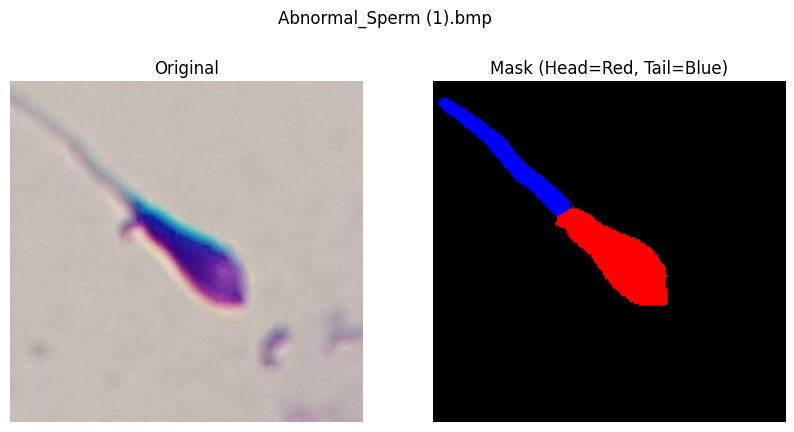


Running inference on: Abnormal_Sperm (10).bmp


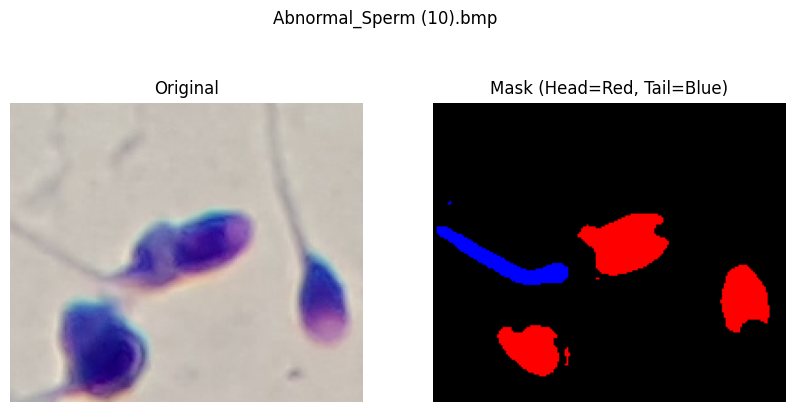


Running inference on: Abnormal_Sperm (100).bmp


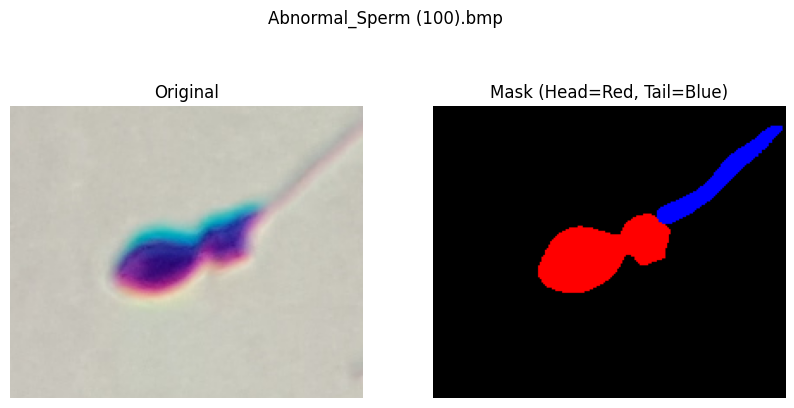


Running inference on: Abnormal_Sperm (1000).bmp


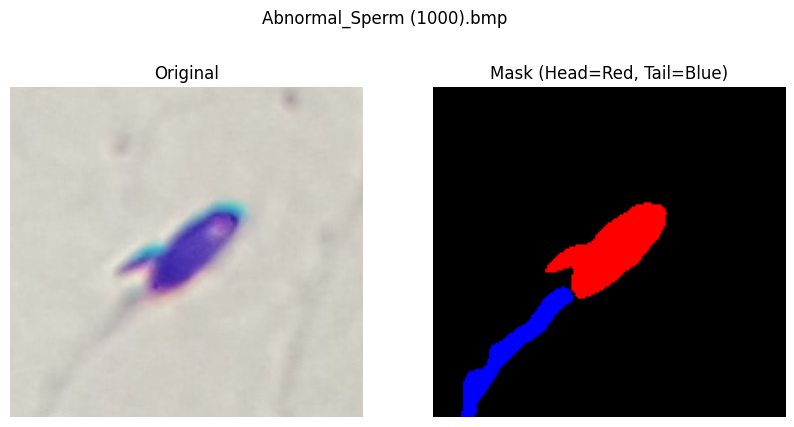


Running inference on: Abnormal_Sperm (1001).bmp


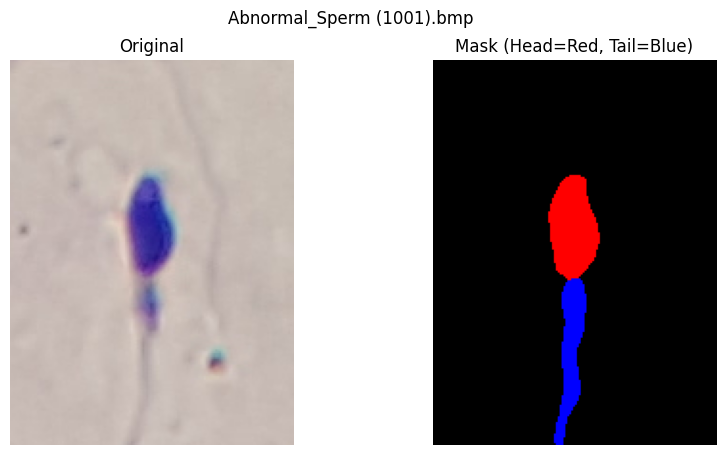

In [ ]:
import matplotlib.pyplot as plt
from pathlib import Path
import cv2

TEST_DIR = Path("/kaggle/input/sperm-datasets/Stained/SMIDS/Abnormal_Sperm")

# Get first 5 BMP images (case-sensitive FS)
test_images = sorted(
    list(TEST_DIR.glob("*.BMP")) +
    list(TEST_DIR.glob("*.bmp"))
)[:5]

print("Found test images:", test_images)

def show_prediction(img, overlay, title="Prediction"):
    plt.figure(figsize=(6,6))
    plt.imshow(overlay)
    plt.title(title)
    plt.axis("off")
    plt.show()

# ------------------------
# Run U-Net prediction
# ------------------------
for path in test_images:
    print(f"\nRunning inference on: {path.name}")

    img, head_mask, tail_mask = unet_predict_multiclass(str(path))
    mask_img = build_colored_mask(head_mask, tail_mask)

    show_side_by_side(img, mask_img, title=path.name)


In [ ]:
from pathlib import Path
import os

BASE_INPUT = Path("/kaggle/input/sperm-datasets/Stained/SMIDS")
BASE_OUTPUT = Path("/kaggle/working/SMIDS_mask")

# Create output folder tree
for cls in ["Normal_Sperm", "Abnormal_Sperm", "Non_Sperm"]:
    (BASE_OUTPUT / cls).mkdir(parents=True, exist_ok=True)

print("Output directories created!")

Output directories created!


In [ ]:
import cv2
import numpy as np
from tqdm import tqdm

def count_head_instances(head_mask):
    head_mask_uint8 = (head_mask > 0).astype(np.uint8)
    num_labels, _ = cv2.connectedComponents(head_mask_uint8)
    return num_labels - 1  # background excluded

classes = ["Normal_Sperm", "Abnormal_Sperm", "Non_Sperm"]

for cls in classes:
    print(f"\nProcessing folder: {cls}")
    input_dir  = BASE_INPUT / cls
    output_dir = BASE_OUTPUT / cls
    output_dir.mkdir(parents=True, exist_ok=True)

    bmp_files = sorted(
        list(input_dir.glob("*.bmp")) +
        list(input_dir.glob("*.BMP"))
    )

    for path in tqdm(bmp_files):
        stem = path.stem

        try:
            num = int(stem.split("(")[1][0])
        except:
            print("Skipping invalid filename:", path)
            continue

        # ---- Multiclass U-Net inference ----
        img, head_mask, tail_mask = unet_predict_multiclass(str(path))

        # ---- Enforce SINGLE-HEAD rule ----
        num_heads = count_head_instances(head_mask)
        if num_heads != 1:
           continue

        # ---- Build RGB mask image ----
        mask_img = build_colored_mask(head_mask, tail_mask)

        # ---- Save ----
        save_path = output_dir / f"{stem}.bmp"
        cv2.imwrite(str(save_path), cv2.cvtColor(mask_img, cv2.COLOR_RGB2BGR))

print("\nAll SINGLE-HEAD multiclass masks generated and saved!")


Processing folder: Normal_Sperm


100%|██████████| 1021/1021 [00:24<00:00, 41.99it/s]



Processing folder: Abnormal_Sperm


100%|██████████| 1005/1005 [00:23<00:00, 42.25it/s]



Processing folder: Non_Sperm


100%|██████████| 974/974 [00:23<00:00, 42.03it/s]


All SINGLE-HEAD multiclass masks generated and saved!


# Pix2pix training

In [14]:
import os
from pathlib import Path
import numpy as np
import cv2
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.layers import Input, Concatenate, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Dropout, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam

2026-01-06 13:11:42.911035: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767705103.096957      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767705103.147167      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767705103.573489      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767705103.573519      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767705103.573522      55 computation_placer.cc:177] computation placer alr

In [ ]:
MASK_ROOT = Path("/kaggle/working/SMIDS_mask")
IMG_ROOT  = Path("/kaggle/input/sperm-datasets/Stained/SMIDS")

classes = ["Normal_Sperm", "Abnormal_Sperm", "Non_Sperm"]
IMG_SIZE = 256  # train at 256x256

def read_rgb(path, size=256):
    img = cv2.imread(str(path), cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f"Cannot read: {path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)
    return img

A_list, B_list = [], []
missing = 0

for cls in classes:
    mask_dir = MASK_ROOT / cls
    img_dir  = IMG_ROOT  / cls
    
    mask_files = sorted(list(mask_dir.glob("*.BMP")) + list(mask_dir.glob("*.bmp")))
    for mpath in mask_files:
        # Match by same filename in original folder
        ipath = img_dir / mpath.name
        if not ipath.exists():
            missing += 1
            continue

        A = read_rgb(mpath, IMG_SIZE)  # mask RGB (black/red/blue)
        B = read_rgb(ipath, IMG_SIZE)  # original RGB
        A_list.append(A)
        B_list.append(B)

print("Pairs:", len(A_list), "Missing:", missing)

trainA = np.array(A_list, dtype=np.float32)
trainB = np.array(B_list, dtype=np.float32)

# Scale to [-1, 1] for tanh output
trainA = (trainA / 127.5) - 1.0
trainB = (trainB / 127.5) - 1.0

dataset = (trainA, trainB)
target_shape = (IMG_SIZE, IMG_SIZE, 3)

Pairs: 3000 Missing: 0


In [16]:
def define_discriminator(image_shape):
    init = RandomNormal(stddev=0.02)

    in_src = Input(shape=image_shape, name="input_image")
    in_tar = Input(shape=image_shape, name="target_image")

    merged = Concatenate()([in_src, in_tar])

    d = Conv2D(64, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(merged)
    d = LeakyReLU(0.2)(d)

    d = Conv2D(128, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(0.2)(d)

    d = Conv2D(256, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(0.2)(d)

    d = Conv2D(512, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(0.2)(d)

    d = Conv2D(512, (4,4), padding="same", kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(0.2)(d)

    patch_out = Conv2D(1, (4,4), padding="same", kernel_initializer=init)(d)

    model = Model([in_src, in_tar], patch_out, name="discriminator")
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=opt)
    return model

def define_generator(image_shape=(256,256,3)):
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=image_shape)

    # Encoder
    e1 = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    e1 = LeakyReLU(0.2)(e1)

    e2 = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e1)
    e2 = BatchNormalization()(e2); e2 = LeakyReLU(0.2)(e2)

    e3 = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e2)
    e3 = BatchNormalization()(e3); e3 = LeakyReLU(0.2)(e3)

    e4 = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e3)
    e4 = BatchNormalization()(e4); e4 = LeakyReLU(0.2)(e4)

    e5 = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e4)
    e5 = BatchNormalization()(e5); e5 = LeakyReLU(0.2)(e5)

    e6 = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e5)
    e6 = BatchNormalization()(e6); e6 = LeakyReLU(0.2)(e6)

    e7 = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e6)
    e7 = BatchNormalization()(e7); e7 = LeakyReLU(0.2)(e7)

    # Bottleneck
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)

    # Decoder
    d1 = Conv2DTranspose(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(b)
    d1 = BatchNormalization()(d1); d1 = Dropout(0.5)(d1)
    d1 = Concatenate()([d1, e7])

    d2 = Conv2DTranspose(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d1)
    d2 = BatchNormalization()(d2); d2 = Dropout(0.5)(d2)
    d2 = Concatenate()([d2, e6])

    d3 = Conv2DTranspose(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d2)
    d3 = BatchNormalization()(d3)
    d3 = Concatenate()([d3, e5])

    d4 = Conv2DTranspose(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d3)
    d4 = BatchNormalization()(d4)
    d4 = Concatenate()([d4, e4])

    d5 = Conv2DTranspose(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d4)
    d5 = BatchNormalization()(d5)
    d5 = Concatenate()([d5, e3])

    d6 = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d5)
    d6 = BatchNormalization()(d6)
    d6 = Concatenate()([d6, e2])

    d7 = Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d6)
    d7 = BatchNormalization()(d7)
    d7 = Concatenate()([d7, e1])

    g = Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)

    return Model(in_image, out_image, name="generator")

In [17]:
def define_gan(g_model, d_model, image_shape, lambda_l1=100.0):
    d_model.trainable = False

    in_src = Input(shape=image_shape)
    gen_out = g_model(in_src)
    dis_out = d_model([in_src, gen_out])

    gan = Model(in_src, [dis_out, gen_out], name="pix2pix_gan")
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    gan.compile(
        loss=[tf.keras.losses.BinaryCrossentropy(from_logits=True), "mae"],
        loss_weights=[1.0, lambda_l1],
        optimizer=opt
    )
    return gan

In [ ]:
# =========================
# PyTorch Pix2Pix (brief)
# =========================
import os, cv2, numpy as np
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch, torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 256
BATCH = 4
EPOCHS = 50
LAMBDA_L1 = 100.0

MASK_ROOT = Path("/kaggle/working/SMIDS_mask")
IMG_ROOT  = Path("/kaggle/input/sperm-datasets/Stained/SMIDS")
CLASSES = ["Normal_Sperm", "Abnormal_Sperm", "Non_Sperm"]

# -------------------------
# Dataset
# -------------------------
tfm = transforms.Compose([
    transforms.ToTensor(),            # [0,1]
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.Normalize((0.5,)*3,(0.5,)*3)  # [-1,1]
])

class Pix2PixDataset(Dataset):
    def __init__(self):
        self.pairs=[]
        for c in CLASSES:
            for m in (MASK_ROOT/c).glob("*.bmp"):
                i = (IMG_ROOT/c/m.name)
                if i.exists(): self.pairs.append((m,i))
    def __len__(self): return len(self.pairs)
    def __getitem__(self, idx):
        m,i = self.pairs[idx]
        A = cv2.cvtColor(cv2.imread(str(m)), cv2.COLOR_BGR2RGB)
        B = cv2.cvtColor(cv2.imread(str(i)), cv2.COLOR_BGR2RGB)
        A = tfm(A); B = tfm(B)
        return A, B

loader = DataLoader(Pix2PixDataset(), batch_size=BATCH, shuffle=True)

# -------------------------
# Models
# -------------------------
def down(in_c,out_c, bn=True):
    l=[nn.Conv2d(in_c,out_c,4,2,1,bias=not bn)]
    if bn: l+=[nn.BatchNorm2d(out_c)]
    l+=[nn.LeakyReLU(0.2,True)]
    return nn.Sequential(*l)

def up(in_c,out_c, drop=False):
    l=[nn.ConvTranspose2d(in_c,out_c,4,2,1,bias=False),
       nn.BatchNorm2d(out_c),
       nn.ReLU(True)]
    if drop: l+=[nn.Dropout(0.5)]
    return nn.Sequential(*l)

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.d1=down(3,64,False); self.d2=down(64,128)
        self.d3=down(128,256); self.d4=down(256,512)
        self.d5=down(512,512); self.d6=down(512,512)
        self.d7=down(512,512); self.b=down(512,512)
        self.u1=up(512,512,True); self.u2=up(1024,512,True)
        self.u3=up(1024,512); self.u4=up(1024,512)
        self.u5=up(1024,256); self.u6=up(512,128)
        self.u7=up(256,64)
        self.out=nn.Sequential(
            nn.ConvTranspose2d(128,3,4,2,1), nn.Tanh()
        )
    def forward(self,x):
        d1=self.d1(x); d2=self.d2(d1); d3=self.d3(d2); d4=self.d4(d3)
        d5=self.d5(d4); d6=self.d6(d5); d7=self.d7(d6); b=self.b(d7)
        u1=self.u1(b); u2=self.u2(torch.cat([u1,d7],1))
        u3=self.u3(torch.cat([u2,d6],1)); u4=self.u4(torch.cat([u3,d5],1))
        u5=self.u5(torch.cat([u4,d4],1)); u6=self.u6(torch.cat([u5,d3],1))
        u7=self.u7(torch.cat([u6,d2],1))
        return self.out(torch.cat([u7,d1],1))

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net=nn.Sequential(
            nn.Conv2d(6,64,4,2,1), nn.LeakyReLU(0.2,True),
            down(64,128), down(128,256), down(256,512),
            nn.Conv2d(512,1,4,1,1)
        )
    def forward(self,a,b): return self.net(torch.cat([a,b],1))

G, D = Generator().to(DEVICE), Discriminator().to(DEVICE)

# -------------------------
# Training
# -------------------------
optG = optim.Adam(G.parameters(), 2e-4, betas=(0.5,0.999))
optD = optim.Adam(D.parameters(), 2e-4, betas=(0.5,0.999))
bce = nn.BCEWithLogitsLoss()
l1  = nn.L1Loss()

for ep in range(EPOCHS):
    for A,B in tqdm(loader, desc=f"Epoch {ep+1}/{EPOCHS}"):
        A,B = A.to(DEVICE), B.to(DEVICE)
        # D
        fake = G(A).detach()
        d_real = D(A,B); d_fake = D(A,fake)
        lossD = (bce(d_real, torch.ones_like(d_real)) +
                 bce(d_fake, torch.zeros_like(d_fake)))*0.5
        optD.zero_grad(); lossD.backward(); optD.step()
        # G
        fake = G(A)
        g_adv = bce(D(A,fake), torch.ones_like(d_real))
        g_l1  = l1(fake,B)*LAMBDA_L1
        lossG = g_adv + g_l1
        optG.zero_grad(); lossG.backward(); optG.step()
    torch.save(G.state_dict(), f"/kaggle/working/pix2pix_G_ep{ep+1}.pth")


Epoch 50/50: 100%|██████████| 750/750 [01:08<00:00, 10.96it/s]


In [19]:
print(torch.cuda.is_available())
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
True
1


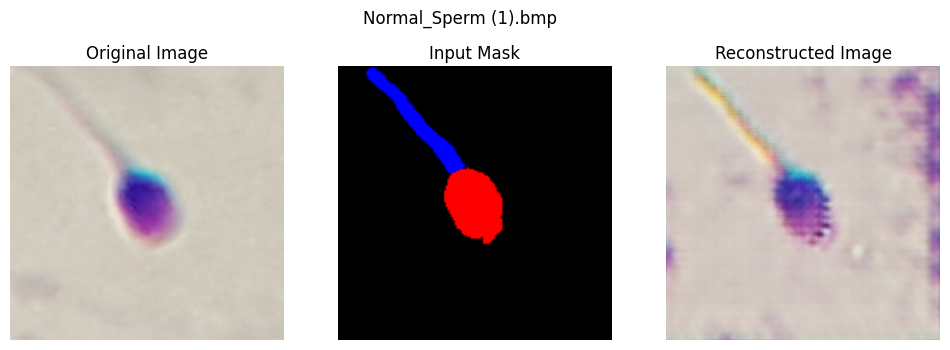

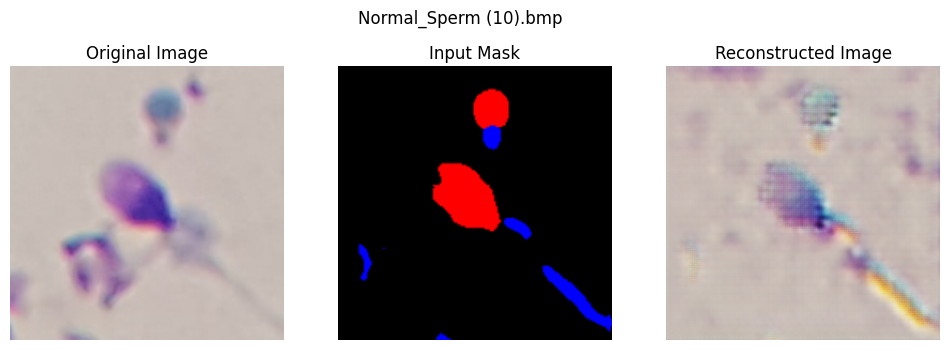

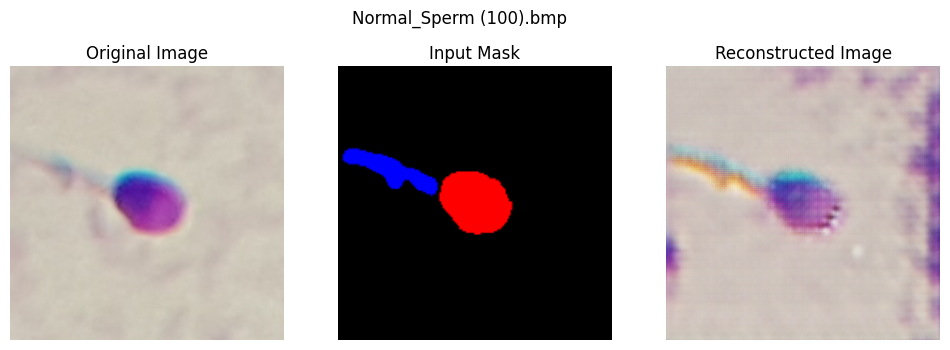

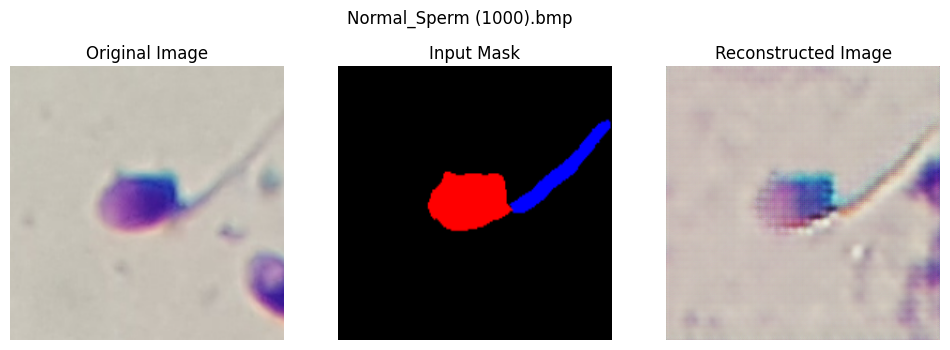

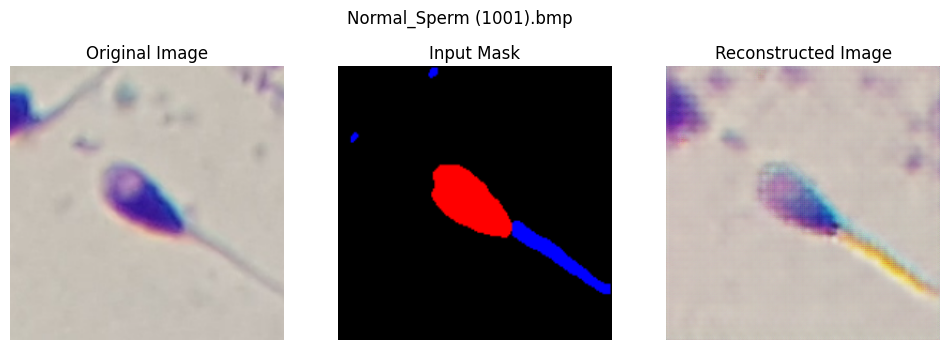

In [ ]:
# =========================
# Test Pix2Pix Generator (3-way visualization)
# =========================
import cv2, torch, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from torchvision import transforms

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 256

# -------- load generator --------
G = Generator().to(DEVICE)
G.load_state_dict(torch.load(
    "/kaggle/working/pix2pix_G_ep50.pth",
    map_location=DEVICE
))
G.eval()

# -------- transforms --------
tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Normalize((0.5,)*3, (0.5,)*3)
])

def denorm(x):
    return ((x + 1) / 2).clamp(0,1)

# -------- paths --------
MASK_DIR = Path("/kaggle/working/SMIDS_mask/Normal_Sperm")
IMG_DIR  = Path("/kaggle/input/sperm-datasets/Stained/SMIDS/Normal_Sperm")

mask_paths = sorted(MASK_DIR.glob("*.bmp"))[:5]

for p in mask_paths:
    # --- load mask ---
    mask = cv2.cvtColor(cv2.imread(str(p)), cv2.COLOR_BGR2RGB)
    x = tfm(mask).unsqueeze(0).to(DEVICE)

    # --- generate image ---
    with torch.no_grad():
        fake = G(x)

    # --- load original image (same filename) ---
    img_path = IMG_DIR / p.name
    orig = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
    orig = cv2.resize(orig, (IMG_SIZE, IMG_SIZE))

    # --- tensors to numpy ---
    inp  = denorm(x[0]).permute(1,2,0).cpu().numpy()
    out  = denorm(fake[0]).permute(1,2,0).cpu().numpy()

    # --- plot ---
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.imshow(orig)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(inp)
    plt.title("Input Mask")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(out)
    plt.title("Reconstructed Image")
    plt.axis("off")

    plt.suptitle(p.name)
    plt.show()

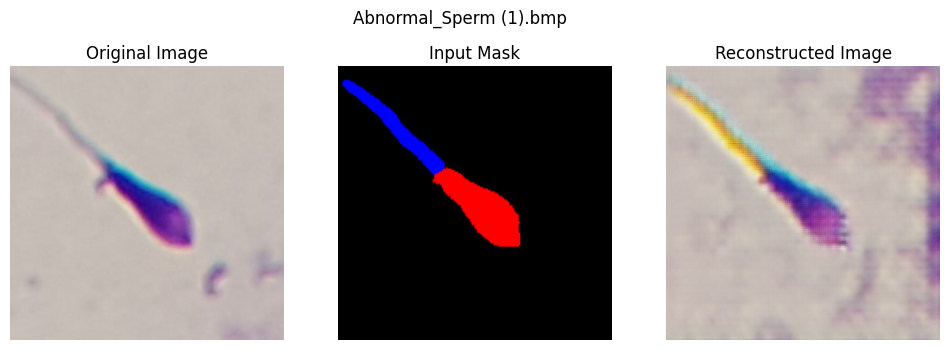

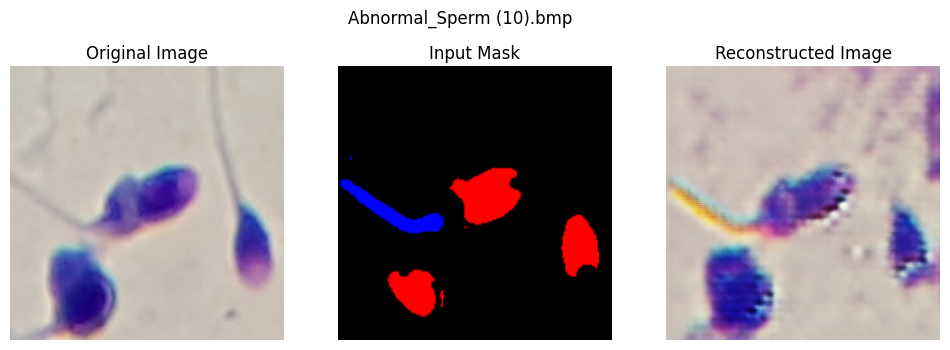

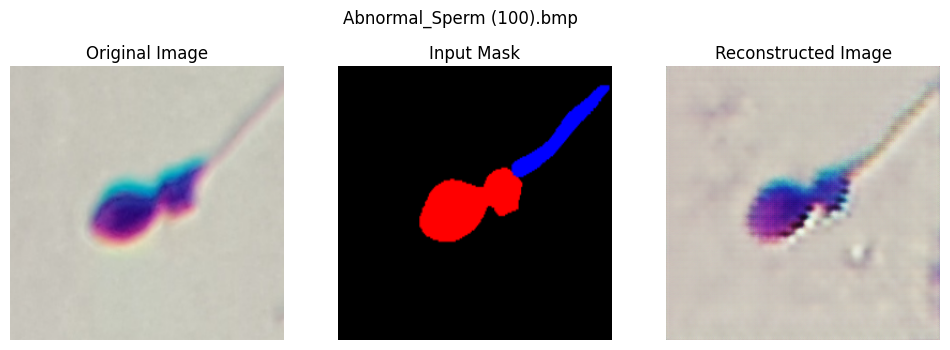

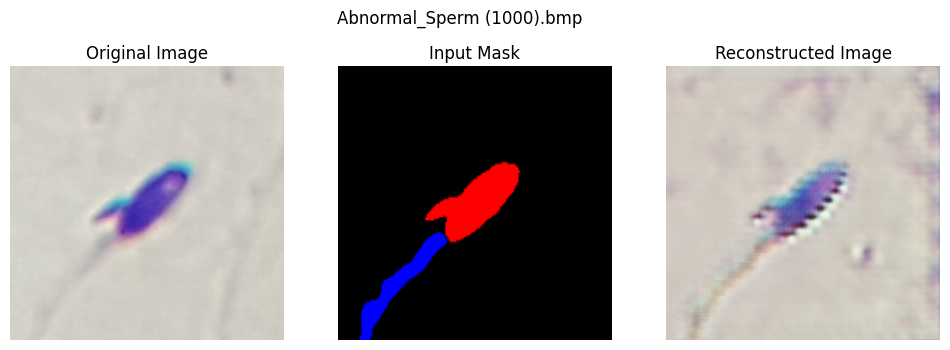

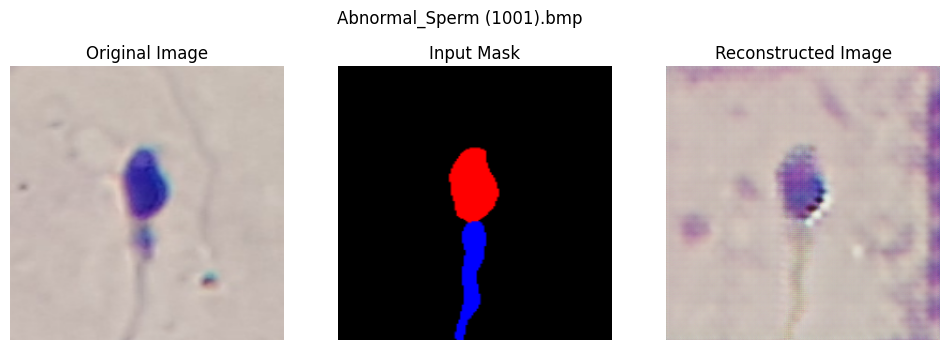

In [ ]:
# -------- paths --------
MASK_DIR = Path("/kaggle/working/SMIDS_mask/Abnormal_Sperm")
IMG_DIR  = Path("/kaggle/input/sperm-datasets/Stained/SMIDS/Abnormal_Sperm")

mask_paths = sorted(MASK_DIR.glob("*.bmp"))[:5]

for p in mask_paths:
    # --- load mask ---
    mask = cv2.cvtColor(cv2.imread(str(p)), cv2.COLOR_BGR2RGB)
    x = tfm(mask).unsqueeze(0).to(DEVICE)

    # --- generate image ---
    with torch.no_grad():
        fake = G(x)

    # --- load original image (same filename) ---
    img_path = IMG_DIR / p.name
    orig = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
    orig = cv2.resize(orig, (IMG_SIZE, IMG_SIZE))

    # --- tensors to numpy ---
    inp  = denorm(x[0]).permute(1,2,0).cpu().numpy()
    out  = denorm(fake[0]).permute(1,2,0).cpu().numpy()

    # --- plot ---
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.imshow(orig)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(inp)
    plt.title("Input Mask")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(out)
    plt.title("Reconstructed Image")
    plt.axis("off")

    plt.suptitle(p.name)
    plt.show()

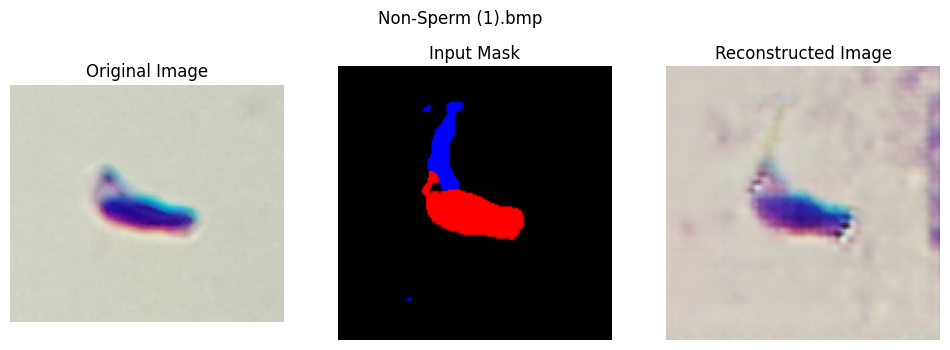

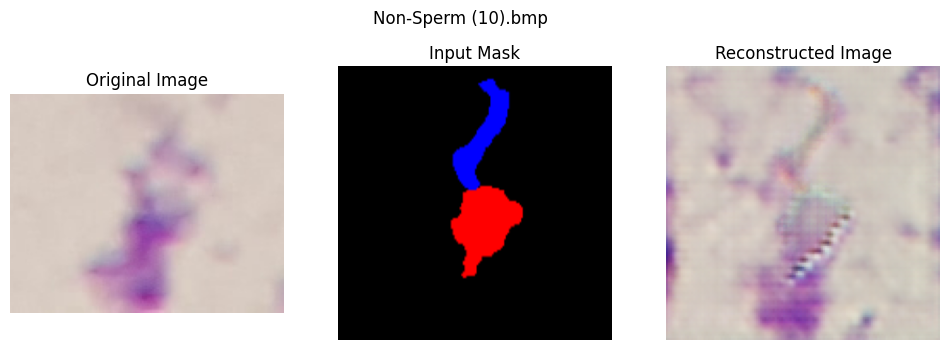

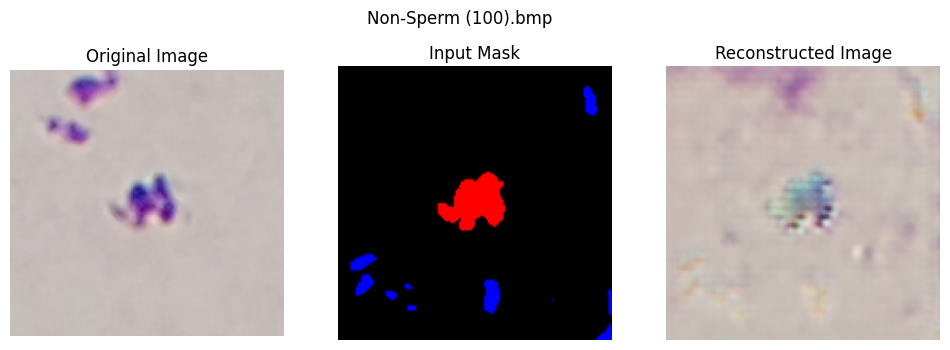

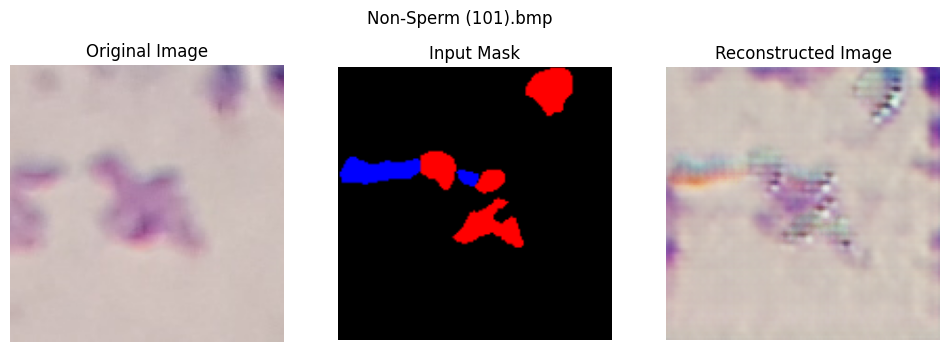

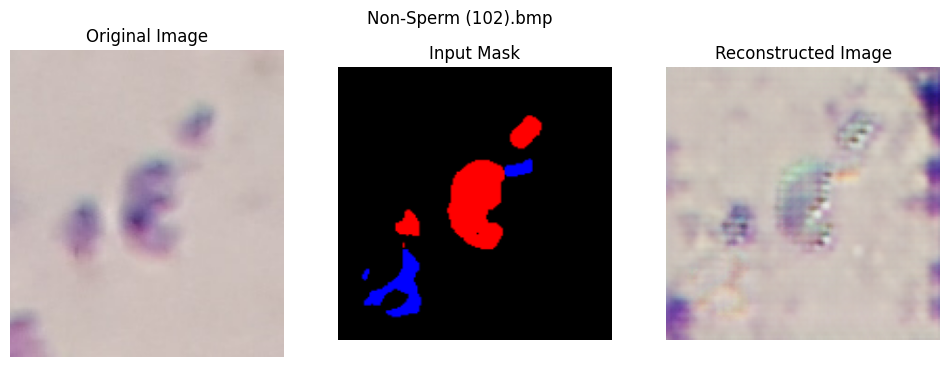

In [ ]:
# -------- paths --------
MASK_DIR = Path("/kaggle/working/SMIDS_mask/Non_Sperm")
IMG_DIR  = Path("/kaggle/input/sperm-datasets/Stained/SMIDS/Non_Sperm")

mask_paths = sorted(MASK_DIR.glob("*.bmp"))[:5]

for p in mask_paths:
    # --- load mask ---
    mask = cv2.cvtColor(cv2.imread(str(p)), cv2.COLOR_BGR2RGB)
    x = tfm(mask).unsqueeze(0).to(DEVICE)

    # --- generate image ---
    with torch.no_grad():
        fake = G(x)
    
    # --- load original image (same filename) ---
    img_path = IMG_DIR / p.name
    orig = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
    
    # --- tensors to numpy ---
    inp  = denorm(x[0]).permute(1,2,0).cpu().numpy()
    out  = denorm(fake[0]).permute(1,2,0).cpu().numpy()
    out = cv2.resize(out, (131, 131))
    
    # --- plot ---
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.imshow(orig)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(inp)
    plt.title("Input Mask")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(out)
    plt.title("Reconstructed Image")
    plt.axis("off")

    plt.suptitle(p.name)
    plt.show()

In [23]:
# =========================
# Generate & Save Synthetic Images
# =========================
import cv2, torch
from pathlib import Path
from torchvision import transforms
from tqdm import tqdm

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 256
CLASSES = ["Normal_Sperm", "Abnormal_Sperm", "Non_Sperm"]

# -------- load generator --------
G = Generator().to(DEVICE)
G.load_state_dict(torch.load(
    "/kaggle/working/pix2pix_G_ep50.pth",
    map_location=DEVICE
))
G.eval()

# -------- transforms --------
tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Normalize((0.5,)*3, (0.5,)*3)
])

def denorm(x):
    return ((x + 1) / 2).clamp(0,1)

BASE_MASK = Path("/kaggle/working/SMIDS_mask")
BASE_OUT  = Path("/kaggle/working/SMIDS_synthetic")
BASE_OUT.mkdir(exist_ok=True)

# -------- generate synthetic images --------
for cls in CLASSES:
    print(f"\nGenerating synthetic images for {cls}")
    in_dir  = BASE_MASK / cls
    out_dir = BASE_OUT / cls
    out_dir.mkdir(parents=True, exist_ok=True)

    mask_paths = sorted(list(in_dir.glob("*.bmp")))

    for p in tqdm(mask_paths):
        mask = cv2.cvtColor(cv2.imread(str(p)), cv2.COLOR_BGR2RGB)
        x = tfm(mask).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            fake = G(x)

        out = denorm(fake[0]).permute(1,2,0).cpu().numpy()
        out = (out * 255).astype("uint8")
        out = cv2.cvtColor(out, cv2.COLOR_RGB2BGR)
        out = cv2.resize(out, (131, 131))
        cv2.imwrite(str(out_dir / p.name), out)

print("\n✅ Synthetic images saved to /kaggle/working/SMIDS_synthetic")


Generating synthetic images for Normal_Sperm


100%|██████████| 1021/1021 [00:09<00:00, 110.24it/s]



Generating synthetic images for Abnormal_Sperm


100%|██████████| 1005/1005 [00:09<00:00, 109.27it/s]



Generating synthetic images for Non_Sperm


100%|██████████| 974/974 [00:08<00:00, 110.15it/s]


✅ Synthetic images saved to /kaggle/working/SMIDS_synthetic


In [24]:
!cd /kaggle/working
!zip -r HuSHem_synthetic.zip SMIDS_synthetic

  adding: SMIDS_synthetic/ (stored 0%)
  adding: SMIDS_synthetic/Non_Sperm/ (stored 0%)
  adding: SMIDS_synthetic/Non_Sperm/Non-Sperm (792).bmp (deflated 21%)
  adding: SMIDS_synthetic/Non_Sperm/Non-Sperm (81).bmp (deflated 36%)
  adding: SMIDS_synthetic/Non_Sperm/Non-Sperm (406).bmp (deflated 33%)
  adding: SMIDS_synthetic/Non_Sperm/Non-Sperm (934).bmp (deflated 32%)
  adding: SMIDS_synthetic/Non_Sperm/Non-Sperm (353).bmp (deflated 32%)
  adding: SMIDS_synthetic/Non_Sperm/Non-Sperm (807).bmp (deflated 35%)
  adding: SMIDS_synthetic/Non_Sperm/Non-Sperm (105).bmp (deflated 25%)
  adding: SMIDS_synthetic/Non_Sperm/Non-Sperm (78).bmp (deflated 31%)
  adding: SMIDS_synthetic/Non_Sperm/Non-Sperm (882).bmp (deflated 31%)
  adding: SMIDS_synthetic/Non_Sperm/Non-Sperm (674).bmp (deflated 36%)
  adding: SMIDS_synthetic/Non_Sperm/Non-Sperm (451).bmp (deflated 35%)
  adding: SMIDS_synthetic/Non_Sperm/Non-Sperm (162).bmp (deflated 30%)
  adding: SMIDS_synthetic/Non_Sperm/Non-Sperm (632).bmp (defla